# Machine Learning Demonstrations

In this notebook, we showcase 3 examples of how effectively use the FRESH algorithm, contained within the kdb+/q machine learning toolkit (ML-toolkit).

<div class="alert alert-danger">
To run the below notebook, ensure that dependencies specified in <b>requirements.txt</b> have been correctly installed.
</div>

## Feature Extraction and Selection

Feature extraction and selection are vital components of many machine learning pipelines. Below we implement the [FRESH](https://arxiv.org/pdf/1610.07717v3.pdf) (FeatuRe Extraction and Scalable Hypothesis testing) algorithm.

Feature extraction is the process of building derived, aggregate features from a time series dataset. The features created are designed to characterize the underlying time series in a way that is easier to interpret and often provides a more suitable input to machine learning algorithms.

## Machine Learning Toolkit

The ML-Toolkit contains general use utilities, an implementation of the FRESH (Feature Extraction based on Scalable Hypothesis tests) algorithm and cross validation functions. The primary purpose of these libraries are to provide kdb+/q users with access to commonly-used ML functions for preprocessing data, extracting features and scoring results.

The toolkit is used throughout this notebook and can be loaded using the below syntax.

In [1]:
\l ml/ml.q
.ml.loadfile`:init.q

## Sections

This notebook is split into 3 distinct sections which cover different use cases for the FRESH algorithm.
1. [Bike-Rental Volume Prediction](#Bike-Rental)
2. [Feature Extraction and Time Series Forecasting](#Forecasting)
3. [Abnormal Wafer Detection In Semiconductor Production](#Wafer)

In [2]:
\c 20 100
\l ../utils/graphics.q
\l ../utils/util.q
ptab:.ml.fresh.params

---

<a id='Bike-Rental'></a>
# Bike Rental Volume Prediction

The purpose of this example is to provide an illustration of how the FRESH algorithm can be implemented to aid in forecasting the value of a target variable, without the implementation of data rolling.

The goal is to use hourly bike rental data from the current day to predict if the last hour of the next day will be busier or quieter than the last hour of today.

This example has been chosen to highlight how FRESH could be useful for staff planning, where an employer could use data to anticipate if extra staff are required for the next business day, saving the business money.

## Bike Sharing in Washington D.C. Dataset

The [Bike Sharing in Washington D.C. Dataset](https://www.kaggle.com/marklvl/bike-sharing-dataset) contains hourly and daily counts of rental bikes from 2011-2012 in Capital Bikeshare System in Washington, DC with the corresponding weather and seasonal information.

### Load data

Below we load in data from the Bike Sharing dataset and drop columns which contain zero variance as these are not useful when training a machine learning algorithm.

In [3]:
show 5#tabinit:.ml.dropconstant("IDIIIIIIIIFFFFIII";(),",")0:`:../data/bike_rental.csv
-1"\nShape of data is: ",a:" x "sv string .ml.shape tabinit;

instant dteday     season yr mnth hr holiday weekday workingday weathersit temp atemp  hum  winds..
-------------------------------------------------------------------------------------------------..
1       2011.01.01 1      0  1    0  0       6       0          1          0.24 0.2879 0.81 0    ..
2       2011.01.01 1      0  1    1  0       6       0          1          0.22 0.2727 0.8  0    ..
3       2011.01.01 1      0  1    2  0       6       0          1          0.22 0.2727 0.8  0    ..
4       2011.01.01 1      0  1    3  0       6       0          1          0.24 0.2879 0.75 0    ..
5       2011.01.01 1      0  1    4  0       6       0          1          0.24 0.2879 0.75 0    ..

Shape of data is: 17379 x 17


### Target values

We want to predict if the number of bike rentals will be higher or lower in the last hour of business tomorrow compared to today. We therefore have to create a target vector which will be predicted by a machine learning model.

In [4]:
lasthour:value exec last cnt by dteday from tabinit
targets:lasthour>prev lasthour
update pcnt:100*num%sum num from select num:count i by target from([]target:targets)

target| num pcnt    
------| ------------
0     | 319 43.63885
1     | 412 56.36115


Using a naive solution which states that the number of rentals will always increase, we would be correct ~56% of the time. Therefore, if our procedure and algorithm provide us with any new insights into the data our predictions will be more than 56% correct on a consistent basis.

### Feature extraction

To extract features provided in the FRESH library from the dataset `.ml.fresh.params` must be called. This is a table containing available functions and corresponding parameters to be applied to the data. Parameters and functions can be altered by updating the valid column of this table, an example is shown below.

In [5]:
/ set unwanted functions to invalid
show 5#dict:update valid:0b from ptab where f in`c3`numpeaks`quantile`fftcoeff`spktwelch`ratiobeyondsigma`augfuller

f           | pnum pnames pvals valid
------------| -----------------------
absenergy   | 0                 1    
abssumchange| 0                 1    
aggautocorr | 0                 1    
augfuller   | 0                 0    
count       | 0                 1    


We can now perform feature extracting by using `.ml.createfeatures`, which takes the data, aggregation column, columns to apply the extraction to and the function dictionary as arguments.

In [6]:
show 5#tabraw:.ml.fresh.createfeatures[tabinit;`dteday;2_cols tabinit;dict]
-1"\nShape of data is: ",b:" x "sv string .ml.shape tabraw;

dteday    | season_absenergy season_abssumchange season_count season_countabovemean season_countb..
----------| -------------------------------------------------------------------------------------..
2011.01.01| 24               0                   24           0                     0            ..
2011.01.02| 23               0                   23           0                     0            ..
2011.01.03| 22               0                   22           0                     0            ..
2011.01.04| 23               0                   23           0                     0            ..
2011.01.05| 23               0                   23           0                     0            ..

Shape of data is: 731 x 3345


### Feature selection

Once feature extraction has been completed the importance of each feature can be determined using the statistical tests contained in the `.ml.fresh.significantfeatures` function. Significance testing allows us to reduce the number of features that are passed to the machine learning algorithm. By setting the third parameter of the function to `.28`, the function will return features with a p-value within the top 28th percentile.

In [7]:
sigcols:.ml.fresh.significantfeatures[t:value tabraw;targets;.ml.fresh.percentile .28]
show 5#tabreduced:key[tabraw]!sigcols#t
-1"\nShape of data";
-1"-------------------------------";
-1"Initial dataset:    ",a;
-1"Unfiltered dataset: ",b;
-1"Filtered dataset:   "," x "sv string .ml.shape tabreduced;

dteday    | weekday_absenergy weekday_max weekday_mean weekday_med weekday_min weekday_sumrecurri..
----------| -------------------------------------------------------------------------------------..
2011.01.01| 864               6           6            6           6           144               ..
2011.01.02| 0                 0           0            0           0           0                 ..
2011.01.03| 22                1           1            1           1           22                ..
2011.01.04| 92                2           2            2           2           46                ..
2011.01.05| 207               3           3            3           3           69                ..

Shape of data
-------------------------------
Initial dataset:    17379 x 17
Unfiltered dataset: 731 x 3345
Filtered dataset:   731 x 633


### Prepare data
Before we can train a model, data must be prepared by first converting features to a matrix, filling null values and replacing infinities.

Data will then be split into training and testing sets. Below we select 20% to be present in the testing set.

In [8]:
/ 0 fill nulls and replace infinities
fitvalsfilter:0^mattab value tabreduced
fitvalsfilter:.ml.infreplace fitvalsfilter

/ split into training and testing sets
dict:.ml.traintestsplit[fitvalsfilter;targets;.2]

### Fit and evaluate model

Here we build, fit and evaluate a classification model. A Random Forest is initialized with 200 estimators which will allows for an estimate of the data quality following the completion of feature extraction.

It should be noted that the addition of ``` `verbose pykw 1``` in the model definition will allow users to display the time required for training and associated training loss of the classifier.

In [9]:
/ initialize model
clf:.p.import[`sklearn.ensemble;`:RandomForestClassifier;`n_estimators pykw 200;`random_state pykw 1]

/ fit training data
clf[`:fit][dict`xtrain;dict`ytrain]`;

/ make predictions on testing data
pred:clf[`:predict][dict`xtest]`

/home/deanna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Results

We can now compare the true and predicted target values using a range of metrics, with results displayed in a confusion matrix.

In [10]:
.ml.classreport[dict`ytest;pred]
-1"The number of misclassifications in the filtered dataset is: ",string .ml.sse[dict`ytest;pred];
-1"The accuracy in the filtered dataset is: ",string .ml.accuracy[dict`ytest;pred];

The number of misclassifications in the filtered dataset is: 30
The accuracy in the filtered dataset is: 0.7959184


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7272727 0.8       0.7619048 60     
1        | 0.8518519 0.7931034 0.8214286 87     
avg/total| 0.7895623 0.7965517 0.7916667 147    


tn| 48
fp| 12
fn| 18
tp| 69


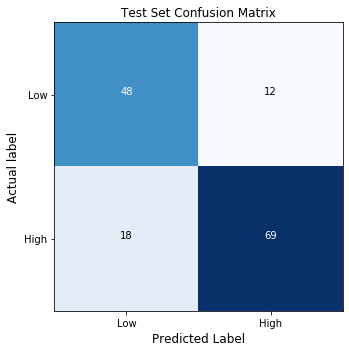

In [11]:
cnfM:.ml.confmat[dict`ytest;pred]
.ml.confdict[dict`ytest;pred;1b]
displayCM[value cnfM;`Low`High;"Test Set Confusion Matrix";()]

### Conclusions

It can be seen from the above results that the use of a Random Forest Classifier allowed us to predict the last hour of business today vs the previous day to a high accuracy compared to the naive case detailed above.

It should be noted that the quality of results is dependant on the location at which the data is split into training and testing sets. This is an inherent problem with making predictions on systems that are influenced by human behaviour as it is difficult to predict outlying cases which have a non-repeating signatures.

---

<a id='Forecasting'></a>
# Feature Extraction and Time Series Forecasting

The purpose of this example is to demonstrate the use of feature extraction and selection as a tool for forecasting the future behaviour of a system. In this case, we use information about the historical behaviour of a stock with the goal of predicting the actual value of the stocks close price the next day.

As is demonstrated in the results section of this notebook, this should **not** be used as a method for stock prediction and is shown here as a use-case to demonstrate the versatility of the algorithm, its use outside of classification and ability to deal with historical data.

## Amazon Stock Dataset

The Amazon Stock Dataset contains data from 1997-2017. Data is provided for the open, high, low, close, volume and open int of a stock.

### Load data

Below we load in the Amazon Stock Dataset and drop columns with zero variance, as with the previous example.

In [12]:
show 5#amzndaydata:.ml.dropconstant lower[cols d]xcol d:("DFFFFJJ";(),",")0:`:../data/amzn_day.us.txt
-1"\nShape of data: ",a:" x "sv string .ml.shape amzndaydata;

date       open high low  close volume  
----------------------------------------
1997.05.16 1.97 1.98 1.71 1.73  14700000
1997.05.19 1.76 1.77 1.62 1.71  6106800 
1997.05.20 1.73 1.75 1.64 1.64  5467200 
1997.05.21 1.64 1.65 1.38 1.43  18853200
1997.05.22 1.44 1.45 1.31 1.4   11776800

Shape of data: 5170 x 6


### Target values

We want to use rolled table forecasting frames to predict the close price for the next day given extracted features from the previous 10 days. The first 10 days were therefore omitted as these would end up being incomplete, due to the rolling frames, and as such may skew our results.

In [13]:
tabletargets:10_amzndaydata
show targets:tabletargets`close

1.51 1.48 1.42 1.54 1.66 1.69 1.58 1.54 1.6 1.58 1.57 1.51 1.51 1.51 1.53 1.5 1.51 1.51 1.51 1.49..


### Preprocessing

Below we produce polynomial features from our data in order to allow for interactions between terms in the system. This allows us to study both combined and individual features.

The date column is removed from the data it is not be required given that the data will be subject to a sliding window which negates its significance as a column.

In [14]:
/ add 2nd order polynomial features to the table
show 5#table:amzndaydata^.ml.polytab[amzndaydata:delete date from amzndaydata;2]

open high low  close volume   open_high open_low open_close open_volume  high_low high_close high..
-------------------------------------------------------------------------------------------------..
1.97 1.98 1.71 1.73  14700000 3.9006    3.3687   3.4081     2.8959e+07   3.3858   3.4254     2.91..
1.76 1.77 1.62 1.71  6106800  3.1152    2.8512   3.0096     1.074797e+07 2.8674   3.0267     1.08..
1.73 1.75 1.64 1.64  5467200  3.0275    2.8372   2.8372     9458256      2.87     2.87       9567..
1.64 1.65 1.38 1.43  18853200 2.706     2.2632   2.3452     3.091925e+07 2.277    2.3595     3.11..
1.44 1.45 1.31 1.4   11776800 2.088     1.8864   2.016      1.695859e+07 1.8995   2.03       1.70..


### Feature Extraction

Below the parameter table has been updated such that we only apply functions without parameters to the dataset. This is achieved by setting rows of the parameter table to invalid for `pnum>0`.

In [15]:
/ make all hyperparameter features invalid
dict:update valid:0b from ptab where pnum>0

/ do not produce aggregated fast fourier transform - this can be computationally expensive
show 5#dict:update valid:0b from dict where f=`fftaggreg

f           | pnum pnames pvals valid
------------| -----------------------
absenergy   | 0                 1    
abssumchange| 0                 1    
aggautocorr | 0                 1    
augfuller   | 0                 1    
count       | 0                 1    


### Rolling table forecasting frame

The following function creates a rolling window, with window lengths `n` on the data and implements feature extraction on each window. Caution should be exercised when applying this to large datasets as the number of calculations required will be:

```q
(1+count table)-n
```

In [16]:
rollcreatefeatures:{[x;f;n]raze createft[;f]each updplacer[x;]each dropswin[n;til count x]}
dropswin :{-1_(x-1)_{1_x,y}\[x#0;y]}
createft :{.ml.fresh.createfeatures[x;`placer;-1_cols x;y]}
updplacer:{update placer:last y from x y}

The next cell produces features extracted by applying a 10-day sliding windows to the data. These features are used in the prediction of the following days close price. 

The keyed column in the output table gives the column number of the last value in each window. 

All incomplete windows have been removed from the application of the sliding window and the window for the last day is not created as this could not be used in the prediction of a target.

In [17]:
show 5#tabraw:rollcreatefeatures[table;dict;10]
-1"\nShape of the forecast data is: ",b:" x "sv string .ml.shape tabraw;

placer| open_absenergy open_abssumchange open_count open_countabovemean open_countbelowmean open_..
------| -----------------------------------------------------------------------------------------..
9     | 26.2488        0.89              10         5                   5                   0    ..
10    | 24.648         0.69              10         4                   6                   0    ..
11    | 23.8913        0.68              10         3                   7                   0    ..
12    | 23.0888        0.64              10         4                   6                   0    ..
13    | 22.4156        0.5               10         6                   4                   0.3  ..

Shape of the forecast data is: 5160 x 630


### Feature significance  

Below is an example of how the k-best features can be determined through significant tests. In the given example k is set to 200.

In [18]:
sigcols:.ml.fresh.significantfeatures[t:value tabraw;targets;.ml.fresh.ksigfeat 200]
show 5#tabreduced:key[tabraw]!sigcols#t
-1"\nShape of data";
-1"-------------------------------";
-1"Initial dataset:    ",a;
-1"Unfiltered dataset: ",b;
-1"Filtered dataset:   "," x "sv string .ml.shape tabreduced;

placer| open_augfuller_teststat open_augfuller_pvalue high_augfuller_teststat high_augfuller_pval..
------| -----------------------------------------------------------------------------------------..
9     | -1.557904               0.5046979             -0                      0.9585321          ..
10    | -0                      0.9585321             -0                      0.9585321          ..
11    | -2.762617               0.06381519            -0                      0.9585321          ..
12    | -0                      0.9585321             -0                      0.9585321          ..
13    | -0                      0.9585321             -0                      0.9585321          ..

Shape of data
-------------------------------
Initial dataset:    5170 x 6
Unfiltered dataset: 5160 x 630
Filtered dataset:   5160 x 200


### Prepare data
Before we can train a model, data must be prepared by first converting features to a matrix and filling null values.

In the below cell, we reintroduce the original data for each day into the dataset. This allows the final dataset to contain both the original and derived datapoints.

In [19]:
rawdata:-1 _9 _amzndaydata
fitvalsfilter:0^mattab rawdata,'value tabreduced
fitvalsraw   :0^mattab rawdata,'value tabraw
newpredictor :0^mattab delete date from rawdata

Data is split into training and testing sets where we select 20% to be present in the testing set. In the below example:

* `dict1` = dictionary with the initial time-series data
* `dict2` = dictionary with the unfiltered data
* `dict3` = dictionary with the filtered data

In [20]:
dict1:.ml.traintestsplit[newpredictor;targets;.2];
dict2:.ml.traintestsplit[fitvalsraw;targets;.2];
dict3:.ml.traintestsplit[fitvalsfilter;targets;.2];

### Fit and evaluate model

Here we train and make predictions on a Gradient Boosting Regressor, where the aim is to predict the close price. Note that the application of regression on financial data can be quite temperamental, with a high dependency the data split which influences the final result.

In [21]:
/ initialize model
gbr:.p.import[`sklearn.ensemble]`:GradientBoostingRegressor
reg:gbr[`learning_rate pykw .1;`n_estimators pykw 200;`random_state pykw rand 1000]

/ fit and predict with initial data
reg[`:fit][dict1`xtrain;dict1`ytrain]`;
pred1:reg[`:predict][dict1`xtest]`

/ fit and predict with unfiltered data
reg[`:fit][dict2`xtrain;dict2`ytrain]`;
pred2:reg[`:predict][dict2`xtest]`

/ fit and predict with filtered data
reg[`:fit][dict3`xtrain;dict3`ytrain]`;
pred3:reg[`:predict][dict3`xtest]`

### Results

Below the mean squared error and R2-score are calculated between the true and predicted target values of the next day close price. These are reasonable indicators of model accuracy. We will compare results with the benchmark which states that today's close price is the best indicator of what tomorrow's close will be.

In [22]:
-1"Mean Squared Error (MSE)";
-1"--------------------------";
-1"Untreated data:  ",string .ml.mse[dict1`ytest;pred1];
-1"Unflitered data: ",string .ml.mse[dict2`ytest;pred2];
-1"Filtered data:   ",string .ml.mse[dict3`ytest;pred3];
-1"\nMSE between current and previous day would be: ",string .ml.mse . 1 -1_\:amzndaydata`close;

Mean Squared Error (MSE)
--------------------------
Untreated data:  40.28125
Unflitered data: 28.58934
Filtered data:   38.79871

MSE between current and previous day would be: 28.48191


In [23]:
-1"R2-score";
-1"--------------------------";
-1"Untreated data:  ",string .ml.r2score[dict1`ytest;pred1];
-1"Unflitered data: ",string .ml.r2score[dict2`ytest;pred2];
-1"Filtered data:   ",string .ml.r2score[dict3`ytest;pred3];
-1"\nR2-score between current and previous day would be: ",string .ml.r2score . 1 -1_\:amzndaydata`close;

R2-score
--------------------------
Untreated data:  0.9993239
Unflitered data: 0.9995769
Filtered data:   0.9993989

R2-score between current and previous day would be: 0.9995275


We can also compare the true and predicted values for the next days close price using a line graph.

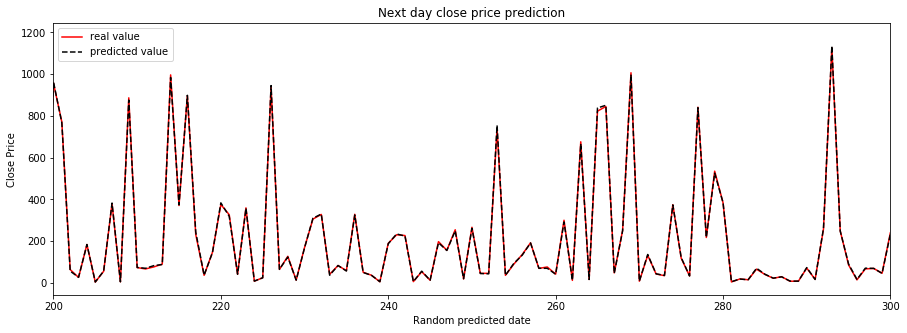

In [24]:
plotprxpred[dict2`ytest;pred2]

### Conclusions

Multiple runs of the above fit and results sections give an indication both of the usefulness of this form of analysis and the difficulty which is posed in the prediction of stock information. 

In the majority of cases it is seen that the mean squared error decreases in the order:

1. Untreated Data
2. Extracted Features without significance testing
3. Extracted Features with significance testing
4. Yesterday's price = Today's price

Large variations in the mean squared error can occur depending on how the data is split by the `.ml.traintestsplit` function. This is related to the inclusion/omission of specific events which would cause large errors in prediction, such as issues with the global economy or issues with staff. It can also have a detrimental effect on the order seen above with variations in this order possible if the features extracted from the split data are not truly indicative of the behaviour of the system.

---

<a id='Wafer'></a>
# Abnormal Wafer Detection In Semiconductor Production

Detecting defects in production processes is an issue of great interest for manufacturing companies. In order for these companies to save money during production, it is important that they invest in systems which can detect malfunctioned or abnormal products early on. These systems are usually comprised of several sensors that measure different features of a device when exposed to distinct conditions over a certain period of time. 

One problem with these systems is that they produce vast amounts of time-series data which has to be interpreted by engineers or data scientists. One solution is therefore to use artificial intelligence. Some tech companies already use machine learning techniques to try and improve their manufacturing pipeline and results have been satisfactory in many cases thanks to well developed processes that range from data preparation to model training. 

In this notebook, the FRESH library is used to pre-process the data and extract significant features. Data is then passed to a Random Forest classifier in order to predict the normality or otherwise of the wafers produced during the manufacturing process.  In a manufacturing environment, it is important to check their quality to allow defective wafers to be removed from the manufacturing pipeline.

## Wafer Database

We are interested in the [Wafer Database](https://www.cs.cmu.edu/~bobski/data/data.html) - a collection of time-series datasets obtained while monitoring an operational semiconductor fabrication plant. In electronics, a wafer is a thin slice of semiconductor material usually employed in the fabrication of integrated circuits, micro-devices or solar cells.

Each dataset in the Wafer Database contains features and associated labels for each wafer, recorded by 6 different sensors during the production of a single wafer with one tool.

All data was previously loaded and pre-processed using kdb+/q post download into its current form of two csv files:
- **data.csv** (8 columns): contains `id` - unique ID for each wafer, `time` - time-series for each ID and 6 signal columns with values from each sensor at each time.
- **labels.csv** (2 columns): contains `id` and `class` - a value of 0 or 1 indicating whether the wafer is considered to be normal or abnormal, where abnormal takes a value of 1 as the positive class, and 0 otherwise.


### Load data
Below we load in in the Wafer Database and check for any null values.

In [25]:
show 5#data:("SIIIIIII";(),",")0:`:../data/waferdata.csv
-1"\nShape of features: ",(a:" x "sv string .ml.shape data),"\n";
show 5#targ:("SI";(),",")0:`:../data/wafertargets.csv
-1"\nShape of targets: "," x "sv string .ml.shape targ;

id      time feat11 feat12 feat15 feat6 feat7 feat8
---------------------------------------------------
1549_01 0    2      -11    -1     3     24    10   
1549_01 1    2      -11    -1     3     25    10   
1549_01 2    2      -11    0      3     24    10   
1549_01 3    2      -11    -1     3     25    10   
1549_01 4    2      -11    0      3     25    477  

Shape of features: 163283 x 8

id      target
--------------
1549_01 1     
1549_02 1     
1549_04 1     
1549_06 1     
1549_07 1     

Shape of targets: 1194 x 2


In [26]:
/check for nulls
count where any null flip data

0


Given that the dataset does not contain any null values and is equally spaced with time, there is no need for the time column to be present. Therefore, it can be removed from the data.

In [27]:
data:delete time from data

### Target values
As the aim is to find features in the time series that indicate whether a wafer is normal or abnormal, this can be treated as a classification problem. It is therefore important to check if there is a balanced distribution between the labels.

In [28]:
target:targ`target
update pcnt:100*num%sum num,wafer:`normal`abnormal from n:select num:count i by target from([]target:target)

target| num  pcnt     wafer   
------| ----------------------
0     | 1067 89.36348 normal  
1     | 127  10.63652 abnormal


The dataset is very unbalanced, with only around 11% of the data belonging to the abnormal class. This would likely have been picked up later in the manufacturing pipeline and could have been costly to the manufacturer.

The class imbalance should be taken into consideration when training the machine learning model, given that it could cause the model to predict that all the wafers are normal, giving a high accuracy, but a useless model. Additionally, this also needs to be taken into account when measuring model performance, where several metrics should be considered in addition to accuracy.

### Feature Extraction

At this stage it is possible to use FRESH to extract additional features that will benefit the model when training. Features are produced based on unique IDs, removing the `id` column during feature extraction.

In [29]:
dict:.ml.fresh.params
show 5#createdfeatures:.ml.fresh.createfeatures[data;`id;1_cols data;dict]
-1"\nShape: ",b:" x "sv string .ml.shape createdfeatures;

id     | feat11_absenergy feat11_abssumchange feat11_count feat11_countabovemean feat11_countbelo..
-------| ----------------------------------------------------------------------------------------..
1549_01| 1.666914e+08     6590                137          98                    39              ..
1549_02| 1.680301e+08     6470                143          99                    44              ..
1549_04| 1.548667e+08     6406                144          98                    46              ..
1549_06| 1.609981e+08     6566                145          98                    47              ..
1549_07| 1.671974e+08     6562                143          99                    44              ..

Shape: 1194 x 1698


### Feature selection

Carrying out statistical-significance tests is useful to determine how useful each created feature is for predicting the target vector.

In the case of binary classification, two types of significance tests are used: Kolmogorov-Smirnov and Fisher-Exact. Each test returns a p-value, which can be passed to the Benjamini-Hochberg-Yekutieli (BHY) procedure. This determines if the feature meets a defined False Discovery Rate (FDR) level (set at 5% by default).

In [30]:
/select significant features
sigcols:.ml.fresh.significantfeatures[t:value createdfeatures;target;.ml.fresh.benjhoch 0.05]
show 5#sigfeattab:key[createdfeatures]!sigcols#t
-1"\nShape of data";
-1"-------------------------------";
-1"Initial dataset:    ",a;
-1"Unfiltered dataset: ",b;
-1"Filtered dataset:   "," x "sv string .ml.shape sigfeattab;

id     | feat11_binnedentropy_numbins_10 feat11_binnedentropy_numbins_5 feat11_ratiobeyondrsigma_..
-------| ----------------------------------------------------------------------------------------..
1549_01| 0.9766542                       0.9112366                      0.379562                 ..
1549_02| 0.9373918                       0.8993726                      0.4055944                ..
1549_04| 0.9640302                       0.8928188                      0.4097222                ..
1549_06| 0.9653513                       0.9278565                      0.4137931                ..
1549_07| 0.9373918                       0.8993726                      0.4055944                ..

Shape of data
-------------------------------
Initial dataset:    163283 x 8
Unfiltered dataset: 1194 x 1698
Filtered dataset:   1194 x 960


### Benchmark

As a benchmark we generate the average value for each feature per id.

In [31]:
show 5#benchmark:select avg feat11,avg feat12,avg feat15,avg feat6,avg feat7,avg feat8 by id from data
benchmarktest:mattab value benchmark

id     | feat11   feat12   feat15    feat6    feat7     feat8   
-------| -------------------------------------------------------
1549_01| 911.7883 657.0219 -70.19708 398.3577 -59.9927  1326.131
1549_02| 875.2867 623.7343 -66.62937 386.951  -61.65035 1260.979
1549_04| 829.2986 575.3889 -52.17361 380.1319 -57.3125  1273.271
1549_06| 843      635.9724 -66.75172 377.2345 -60.23448 1274.641
1549_07| 872.7133 586.3776 -62.42657 386.7133 -63.09091 1261.371


### Prepare data
Before we can train a model, data must be prepared by first converting features to a matrix.

Data will then be split into training and testing sets. Below we select 20% to be present in the testing set.

In [32]:
featmat:mattab value sigfeattab
dict1:.ml.traintestsplit[featmat;target;.2]
dict2:.ml.traintestsplit[benchmarktest;target;.2]

### Fit and evaluate model

At this stage we can fit to a random forest model and make predictions.

Random forests are the preferred algorithms for many machine learning experts. They tend to provide very good results based on decision trees, which are therefore easy to interpret. Additionally, they do not require the appropriate architecture to be built, nor do they require as much training as neural networks.

Results will be able to show how informative the application of feature extraction and significance tests have been in the prediction of the wafer state. They can also be compared to the naive case where all wafers are assumed to be normal.

In [33]:
/ initialize model
rfc:.p.import[`sklearn.ensemble;`:RandomForestClassifier]
clf:rfc[`n_estimators pykw 500;`random_state pykw 50;`verbose pykw 1]

/ train/test model with FRESH features
clf[`:fit][dict1`xtrain;dict1`ytrain]`;
pred1:clf[`:predict][dict1`xtest]`

/ train/test model with benchmark features
clf[`:fit][dict2`xtrain;dict2`ytrain]`;
pred2:clf[`:predict][dict2`xtest]`

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


## Results
To account for the class imbalance in the data, multiple performance metrics have been used - *precision*, *recall*, *f1-score*, *support* and *accuracy*. We will also plot confusion matrices for each model to visualize the results.

In [34]:
/Find naive results
\S 49
naivetrue:(n:count dict2`ytest)?target
naivepred:n#0i

In [35]:
-1"FRESH:";
show .ml.classreport[dict1`ytest;pred1]
-1"\nBenchmark:";
show .ml.classreport[dict2`ytest;pred2]
-1"\nNaive:";
show .ml.classreport[naivetrue;naivepred]

-1"\nNumber misclassified";
-1"-------------------------";
-1"FRESH model:     ",string sum pred1<>dict1`ytest;
-1"Benchmark model: ",string sum pred2<>dict2`ytest;
-1"Naive model:     ",string sum naivetrue<>naivepred;

-1"\nAccuracy score";
-1"-------------------------";
-1"FRESH model:     ",string .ml.accuracy[dict1`ytest;pred1];
-1"Benchmark model: ",string .ml.accuracy[dict2`ytest;pred2];
-1"Naive model:     ",string .ml.accuracy[naivetrue;naivepred];

FRESH:
class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9955157 1         0.9977528 222    
1        | 1         0.9411765 0.969697  17     
avg/total| 0.9977578 0.9705882 0.9837249 239    

Benchmark:
class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9953052 0.9860465 0.9906542 215    
1        | 0.8846154 0.9583333 0.92      24     
avg/total| 0.9399603 0.9721899 0.9553271 239    

Naive:
class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 1         0.9037657 0.9494505 239    
avg/total| 1         0.9037657 0.9494505 239    

Number misclassified
-------------------------
FRESH model:     1
Benchmark model: 4
Naive model:     23

Accuracy score
-------------------------
FRESH model:     0.9958159
Benchmark model: 0.9832636
Naive model:     0.9037657


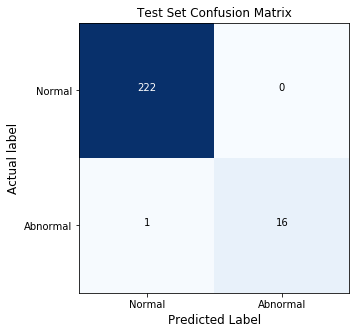

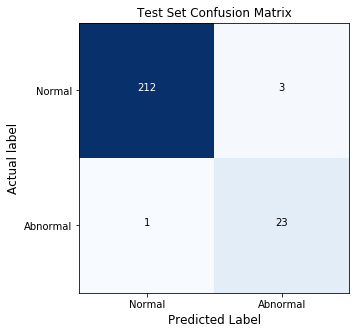

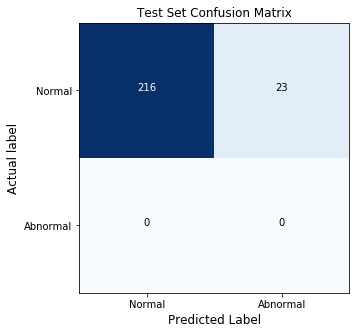

In [36]:
dcm:displayCM[;`Normal`Abnormal;"Test Set Confusion Matrix";()]
dcm value .ml.confmat[dict1`ytest;pred1]
dcm value .ml.confmat[dict2`ytest;pred2]
dcm value .ml.confmat[naivetrue;naivepred]

### Conclusions

Looking at the results produced, it is clear that the dataset that used the FRESH library produced better performance metrics than both the benchmark and naive models. By using FRESH, we have improved the ability to predict the normality or otherwise of the wafers produced during the manufacturing process. This model produced a much higher accuracy than both alternative models with only 4 wafers misclassified, compared to 7 for the benchmark model and 23 for the naive model.

These results give an insight into the potential use of this form of analysis in the manufacturing sector, particularly given the large volumes of data consistently recorded in modern manufacturing processes. It also offers the potential for reductions in redundant labour and manufacturing procedures thus reducing the overall cost of the manufacturing pipeline.

---